In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Load CSV file
csv_file = "events.csv"
df = pd.read_csv(csv_file)

# Ensure date columns are treated as strings before conversion
df["Start Date"] = df["Start Date"].astype(str)
df["End Date"] = df["End Date"].astype(str)

# Convert date columns to datetime (handle different formats)
df["Start Date"] = pd.to_datetime(df["Start Date"], errors="coerce")
df["End Date"] = pd.to_datetime(df["End Date"], errors="coerce")

# Drop rows with invalid dates
df = df.dropna(subset=["Start Date", "End Date"])

# Calculate event duration in hours
df["Duration (hours)"] = (df["End Date"] - df["Start Date"]).dt.total_seconds() / 3600

# Filter out events containing specific keywords
exclude_keywords = [" - Anniversaire"]
df = df[~df["Event Title"].str.lower().str.contains('|'.join(exclude_keywords), na=False)]

# Expand multi-day events into daily entries
expanded_rows = []

for _, row in df.iterrows():
    start, end = row["Start Date"], row["End Date"]
    # Start from the event's start date (00:00:00)
    current_day = start.normalize()

    while current_day <= end.normalize():
        next_day = current_day + pd.Timedelta(days=1) # Move to the next day

        # Compute hours for this specific day
        start_time = max(start, current_day)
        end_time = min(end, next_day)
        duration_hours = (end_time - start_time).total_seconds() / 3600

        expanded_rows.append({
            "Date": current_day,
            "Duration (hours)": duration_hours
        })

        current_day = next_day

# Create a new DataFrame with correctly distributed event durations
df_expanded = pd.DataFrame(expanded_rows)

# Create week & weekday columns
df_expanded["Date"] = df_expanded["Date"].dt.tz_localize(None)
df_expanded["Week"] = df_expanded["Date"].dt.to_period("W").apply(lambda x: x.start_time.strftime("%Y-%m-%d"))
df_expanded["Weekday"] = df_expanded["Date"].dt.weekday
df = df_expanded

In [3]:
def plot_week_agg(df):
    # Ensure empty weeks are included
    weekly_duration = df[["Duration (hours)", "Week"]].groupby("Week").agg("sum")
    if not df.empty:
        min_week = df["Week"].min()
        max_week = df["Week"].max()

        all_weeks = pd.date_range(start=min_week, end=max_week, freq="W-MON").strftime("%Y-%m-%d")
        all_weeks_df = pd.DataFrame({"Week": all_weeks})

        # Merge with actual data, filling missing weeks with 0 duration
        weekly_duration = all_weeks_df.merge(weekly_duration, on="Week", how="left").fillna(0)

    # Calculate statistics
    average_duration = df["Duration (hours)"].mean()
    total_events = len(df)

    # Plot weekly aggregated duration
    plt.figure(figsize=(12, 6))
    plt.bar(weekly_duration["Week"], weekly_duration["Duration (hours)"], color="skyblue")
    plt.xlabel("Week")
    plt.ylabel("Total Duration (hours)")
    plt.title("Weekly Aggregated Event Durations (After 01.01.2025)")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show statistics
    print(f"Total Events After Filtering: {total_events}")
    print(f"Average Event Duration: {average_duration:.2f} hours")
    plt.show()

Total Events After Filtering: 46
Average Event Duration: 4.17 hours


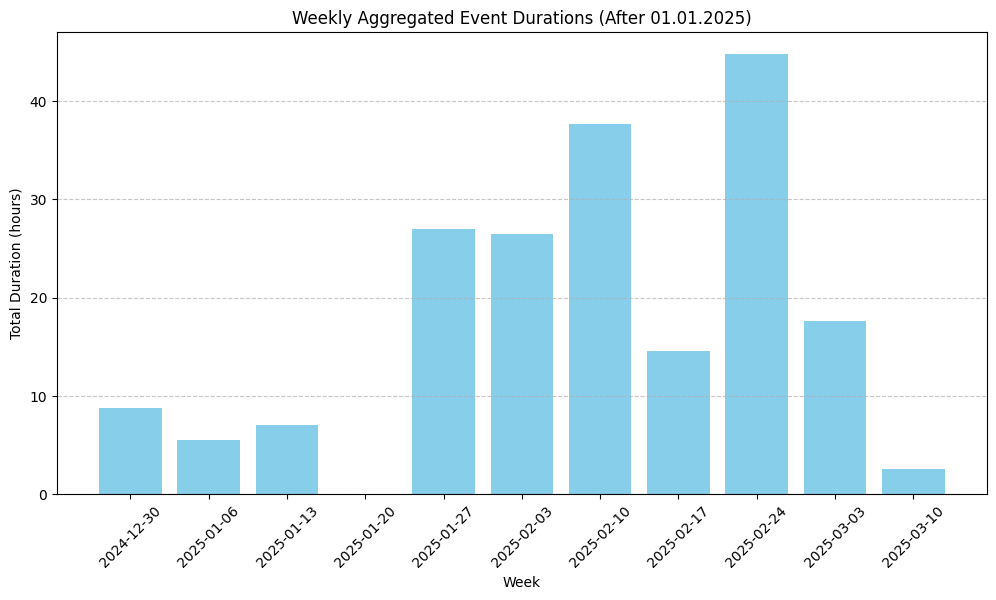

In [4]:
plot_week_agg(df[df["Date"] >= "2025-01-01"])

In [5]:
def plot_heatmap_calendar(df):
    # Aggregate event duration for each weekday per week
    heatmap_data = df.pivot_table(index="Week", columns="Weekday", values="Duration (hours)", aggfunc="sum").fillna(0)

    # Sort weeks in chronological order
    heatmap_data = heatmap_data.sort_index()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(heatmap_data, cmap="Reds", annot=True, fmt=".1f", linewidths=0.5, cbar_kws={"label": "Event Duration (hours)"})

    # Format labels
    plt.xlabel("Weekday")
    plt.ylabel("Week (Start Date)")
    plt.xticks(ticks=np.arange(7) + 0.5, labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=0)
    plt.title("Weekly Calendar Grid: Event Durations (Hours)")
    plt.show()

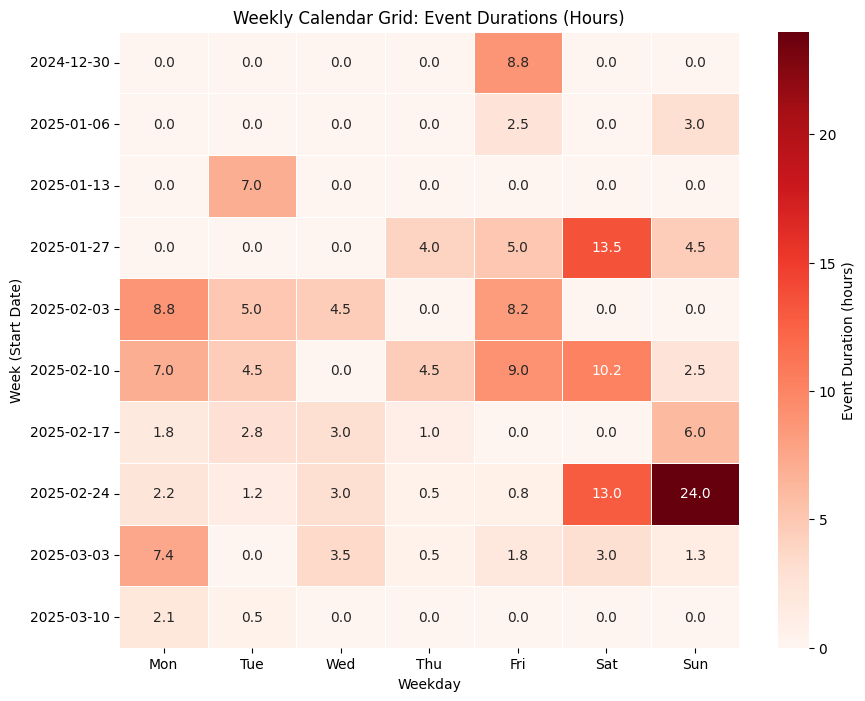

In [6]:
plot_heatmap_calendar(df[df["Date"] >= "2025-01-01"])

In [7]:
def plot_heatmap_calendar(df):
    df = df.copy()
    # Ensure all weeks are included, even if they have no events
    df.loc[:, 'Week'] = pd.to_datetime(df['Week'])
    all_weeks = pd.date_range(start=df['Week'].min(), end=df['Week'].max(), freq='W-MON')
    all_weeks_str = all_weeks.strftime('%Y-%m-%d')

    # Aggregate durations as lists
    heatmap_data = df.groupby(["Week", "Weekday"])["Duration (hours)"].apply(list).unstack(fill_value=[])

    # Ensure all weeks exist in the dataset
    heatmap_data = heatmap_data.reindex(all_weeks_str, fill_value=[])
    weekly_totals = heatmap_data.sum(axis=1)

    weeks = heatmap_data.index
    weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

    fig, ax = plt.subplots(figsize=(10, 10))

    for i, week in enumerate(weeks):
        for j, weekday in enumerate(weekdays):
            durations = heatmap_data.loc[week, j] if j in heatmap_data.columns else []
            num_events = len(durations)

            # Define cell boundaries
            x_start, y_start = j, i
            width, height = 1, 1

            # Choose color intensity based on max duration
            max_duration = sum(durations) if durations else 0
            color_intensity = min(max_duration / 11, 1.)

            ax.add_patch(plt.Rectangle((x_start, y_start), width, height,
                                       color=plt.cm.Reds(color_intensity), ec="black"))

            # Display date
            week_start = datetime.datetime.strptime(week, '%Y-%m-%d')
            if pd.notna(week_start):
                date_str = (week_start + pd.Timedelta(days=j)).strftime("%d.%m")
                ax.text(x_start + 0.05, y_start + 0.1, date_str,
                        ha="left", va="top", fontsize=6, color="black", alpha=0.8)

            if num_events > 0:
                # Split the cell into equal parts
                for k, duration in enumerate(durations):
                    split_height = height / num_events
                    y_pos = y_start + (k * split_height)

                    ax.add_patch(plt.Rectangle((x_start, y_pos), width, split_height,
                                               color=plt.cm.Reds(color_intensity), ec="gray", lw=0.5))
                    ax.text(x_start + 0.5, y_pos + split_height / 2, f"{duration:.1f}h",
                            ha="center", va="center", fontsize=10, color="black")

        # Add weekly total to the right
        ax.text(len(weekdays) + 0.5, i + 0.5, f"{sum(weekly_totals.iloc[i]):.1f}h", ha="left", va="center", fontsize=10, color="black", fontweight='bold')

    # Add weekly total to the right
    ax.text(len(weekdays) + 1.5, i + 0.5, f"Total {sum(weekly_totals.values.sum()):.1f}h", ha="left", va="center", fontsize=10, color="black", fontweight='bold')

    ax.set_xlim(0., len(weekdays))
    ax.set_ylim(0., len(weeks))
    # Reverse y-axis so latest dates are at the bottom
    ax.invert_yaxis()

    # Labels & Formatting
    ax.set_xticks(np.arange(len(weekdays)) + 0.5)
    ax.set_xticklabels(weekdays, ha="center", va="center", fontsize=10)
    ax.set_yticks(np.arange(len(weeks)) + 0.5)
    ax.set_yticklabels([datetime.datetime.strptime(w, '%Y-%m-%d').strftime("%d.%m.%Y") for w in weeks],
                       va="center", ha="right", fontsize=10)
    ax.tick_params(axis="x", pad=10, labelsize=10)
    ax.tick_params(axis="y", pad=5, labelsize=10)

    ax.set_xlabel("Weekday", fontsize=14, labelpad=15)
    ax.set_ylabel("Week (Start Date)", fontsize=14, labelpad=15)
    ax.set_title("Weekly Calendar Grid: Event Durations (Hours)", fontsize=16)

    plt.show()


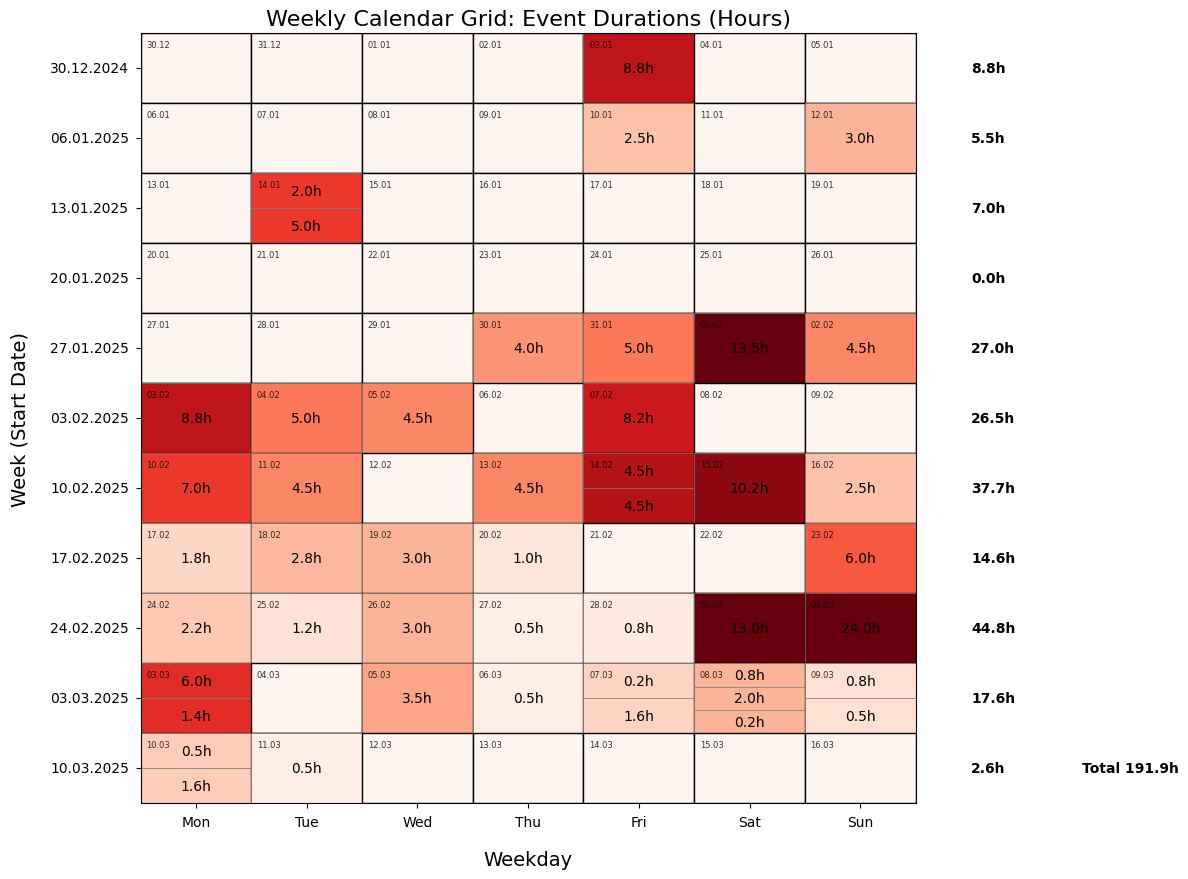

In [8]:
plot_heatmap_calendar(df[df["Date"] >= "2025-01-01"])